# Setup

In [6]:
!pip install osfclient --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet
!pip install keras-hub --quiet
!pip install dotenv --quiet
!pip install scikit-learn --quiet





In [79]:
import os
import tensorflow as tf
import numpy as np

import keras
from keras import ops
import keras_hub

import pandas as pd
import osfclient
from osfclient.api import OSF

import wandb
from wandb.integration.keras import WandbMetricsLogger

from plotnine import ggplot, geom_point, aes, geom_line, geom_histogram, geom_boxplot, geom_ribbon, scale_y_reverse, scale_y_continuous, theme_void, scale_x_continuous, scale_color_manual, scale_fill_manual, ylab, xlab, labs, theme, theme_classic, element_text, element_blank, element_line, facet_wrap

In [3]:
try:
  from google.colab import userdata
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

In [4]:
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet

In [7]:
import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.model_analysis import plot_model_performance

In [25]:
if IN_COLAB:
    os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
    os.environ['OSF_TOKEN'] = userdata.get('osftoken')
    os.environ['OSF_USERNAME'] = userdata.get('osfusername')
else:
    # Load from a .env file using python-dotenv
    from dotenv import load_dotenv
    load_dotenv()
    os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY', '')
    os.environ['OSF_TOKEN'] = os.getenv('OSF_TOKEN', '')
    os.environ['OSF_USERNAME'] = os.getenv('OSF_USERNAME', '')

os.environ['OSF_ANALYSIS_PROJECT_ID'] = "8ecx5"
os.environ["KERAS_BACKEND"] = "tensorflow"

# Configure W&B experiment

In [10]:
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [11]:
EXPERIMENT_ID = "gf1zjs9v"
ENTITY_NAME = "vassar-cogsci-lab"
PROJECT_NAME = "eye-tracking-dense-full-data-set-single-eye"

# Resume the W&B run to add new data
wandb.init(entity=ENTITY_NAME, project=PROJECT_NAME, id=EXPERIMENT_ID, resume="must")

# Download the Model Config and Weights File from W&B

In [12]:
api = wandb.Api()

# https://wandb.ai/vassar-cogsci-lab/eye-tracking-dense-full-data-set-single-eye/runs/up4mb4u3?nw=nwuserjoshdeleeuw
run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{EXPERIMENT_ID}")

config = run.config
run.file("full_model.weights.h5").download(exist_ok=True)

EMBEDDING_DIM = config["embedding_dim"]
RIDGE_REGULARIZATION = config["ridge_regularization"]

In [13]:
# Fixed constants
MAX_TARGETS = 288

# Config constants
EMBEDDING_DIM = config['embedding_dim']
RIDGE_REGULARIZATION = config['ridge_regularization']

BACKBONE = config['backbone']

# Configure OSF Analysis Component Client

In [15]:
analysis_osf = osfclient.OSF(token=os.environ['OSF_TOKEN'])

In [16]:
analysis_osf_project = analysis_osf.project(os.environ['OSF_ANALYSIS_PROJECT_ID'])

UnauthorizedException: 

## Function for saving files locally and uploading to OSF

In [12]:
def upload_to_analysis_osf(analysis_folder, fps):
  for fp in fps:
    local_fp = os.path.join('/content/' + analysis_folder, fp)
    remote_fp = os.path.join(analysis_folder, fp)
    with open(local_fp, 'rb') as f:
      analysis_osf_project.storage().create_file(remote_fp, fp=f, update=True)

# Dataset preparation

## Download dataset from OSF

In [24]:
os.environ['OSF_TOKEN']

'154c08aef6428a4bd07a67ae4e300afd27f4bf22'

In [21]:
!osf fetch

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: the following arguments are required: remote


In [26]:
!osf -p uf2sh fetch single_eye_tfrecords.tar.gz

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: You are not authorized to access this project.


# Process raw data records into TF Dataset

In [27]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [28]:
def parse(element):
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'phase': tf.io.FixedLenFeature([], tf.int64),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    #landmarks = content['landmarks']
    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    phase = content['phase']
    depth = 3
    coords = [content['x'], content['y']]
    subject_id = content['subject_id']

    # landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    # landmarks = tf.reshape(landmarks, shape=(478, 3))

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, phase, coords, subject_id

In [29]:
test_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, phase, coords, subject_id: subject_id
)

2025-05-26 10:34:34.994573: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-05-26 10:34:36.753035: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Rescale the `x,y` coordinates to be 0-1 instead of 0-100.

In [30]:
def rescale_coords_map(img, phase, coords, id):
  return img, phase, tf.divide(coords, tf.constant([100.])), id

In [31]:
test_data_rescaled = test_data.map(rescale_coords_map)

## Prepared masked dataset with phase calibration info

In [32]:
def prepare_masked_dataset(dataset, calibration_points=None, cal_phase=None):
    # Step 1: Group dataset by subject_id and batch all images
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    # Step 2: Filter out subjects with not enough data points （288 total; 144 in each phase)
    def filter_by_image_count(images, phase, coords, subject_ids):
        total_image_count = tf.shape(images)[0] >= MAX_TARGETS
        phase1_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 1), tf.int32)) >= 144
        phase2_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 2), tf.int32)) >= 144
        return tf.logical_and(total_image_count, tf.logical_and(phase1_image_count, phase2_image_count))

   # grouped_dataset = grouped_dataset.filter(filter_by_image_count)

    # Step 3: Transform each batch to include masks
    def add_masks_to_batch(images, phase, coords, subject_ids):

        actual_batch_size = tf.shape(images)[0] # how many total images for a given subject

        print(f'actual_batch_size: {actual_batch_size}')

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        cal_mask = tf.zeros(actual_batch_size, dtype=tf.int8)
        target_mask = tf.zeros(actual_batch_size, dtype=tf.int8)

        if calibration_points is None:
          raise ValueError("Need to specify calibration points in test mode")
        else:
          coords_xpand = tf.expand_dims(coords, axis=1)
          cal_xpand = tf.expand_dims(calibration_points, axis=0)

          # Check which points match calibration points
          equality = tf.equal(coords_xpand, cal_xpand)
          matches = tf.reduce_all(equality, axis=-1)
          point_matches = tf.reduce_any(matches, axis=1)
          cal_mask = tf.cast(point_matches, dtype=tf.int8)

        target_mask = (1 - cal_mask) * phase2_mask

        if cal_phase == 1:
          cal_mask = cal_mask * phase1_mask
        elif cal_phase == 2:
          cal_mask = cal_mask * phase2_mask

        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(
            coords,
            [[0, MAX_TARGETS - actual_batch_size], [0, 0]]
        )
        padded_cal_mask = tf.pad(
            cal_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )
        padded_target_mask = tf.pad(
            target_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])
        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset

In [33]:
def get_subject_id_list(features, labels, subject_ids):
  return subject_ids

In [34]:
def prepare_model_inputs(features, labels, subject_ids):
    images, coords, cal_mask, target_mask = features

    inputs = {
        "Input_All_Images": images,
        "Input_All_Coords": coords,
        "Input_Calibration_Mask": cal_mask,
        "Input_Target_Mask": target_mask
    }

    return inputs, labels, target_mask

In [35]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

In [36]:
masked_dataset_p1 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 1)

masked_dataset_p2 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 2)

masked_dataset_subject_ids = masked_dataset_p1.map(get_subject_id_list)

actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)
actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)


In [37]:
subject_ids = []
for e in masked_dataset_subject_ids.as_numpy_iterator():
  subject_ids.append(e)
subject_ids = np.array(subject_ids).astype(int)

2025-05-26 10:34:52.978135: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
test_ds_p1 = masked_dataset_p1.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_p2 = masked_dataset_p2.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [39]:
# Should be the same for either phase cal choices
SUBJECTS = 0
for e in test_ds_p1.as_numpy_iterator():
  SUBJECTS += 1

In [40]:
SUBJECTS

250

# Re-construct Model



## Custom layers

In [41]:
class SimpleTimeDistributed(keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super().__init__(layer, **kwargs)
        self.supports_masking = getattr(layer, 'supports_masking', False)

    def build(self, input_shape):
        if not isinstance(input_shape, (tuple, list)) or len(input_shape) < 3:
            raise ValueError(
                "`SimpleTimeDistributed` requires input with at least 3 dimensions"
            )

        super().build((input_shape[0], *input_shape[2:]))
        self.built = True

    def compute_output_shape(self, input_shape):
        child_output_shape = self.layer.compute_output_shape((input_shape[0], *input_shape[2:]))
        return (child_output_shape[0], input_shape[1], *child_output_shape[1:])

    def call(self, inputs, training=None):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        time_steps = input_shape[1]

        reshaped_inputs = ops.reshape(inputs, (-1, *input_shape[2:]))

        outputs = self.layer.call(reshaped_inputs, training=training)

        output_shape = ops.shape(outputs)

        return ops.reshape(outputs, (batch_size, time_steps, *output_shape[1:]))

In [42]:
class MaskedWeightedRidgeRegressionLayer(keras.layers.Layer):
    def __init__(self, lambda_ridge, epsilon=1e-6, **kwargs):
        self.lambda_ridge = lambda_ridge
        self.epsilon = epsilon
        super(MaskedWeightedRidgeRegressionLayer, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        embeddings, coords, calibration_weights, cal_mask  = inputs

        embeddings = ops.cast(embeddings, "float32")
        coords = ops.cast(coords, "float32")
        calibration_weights = ops.cast(calibration_weights, "float32")
        cal_mask = ops.cast(cal_mask, "float32")

        w = ops.squeeze(calibration_weights, axis=-1)

        w_masked = w * cal_mask
        w_sqrt = ops.sqrt(w_masked + self.epsilon)
        w_sqrt = ops.expand_dims(w_sqrt, -1)

        cal_mask_expand = ops.expand_dims(cal_mask, -1)
        X = embeddings * cal_mask_expand

        X_weighted = X * w_sqrt
        y_weighted = coords * w_sqrt * cal_mask_expand

        X_t = ops.transpose(X_weighted, axes=[0, 2, 1])
        X_t_X = ops.matmul(X_t, X_weighted)

        identity_matrix = ops.cast(ops.eye(ops.shape(embeddings)[-1]), "float32")
        lhs = X_t_X + self.lambda_ridge * identity_matrix

        rhs = ops.matmul(X_t, y_weighted)

        kernel = tf.linalg.solve(lhs, rhs)

        output = ops.matmul(embeddings, kernel)

        return output


    def compute_output_shape(self, input_shapes):
        unknown_embeddings_shape, _, _, _ = input_shapes
        return unknown_embeddings_shape[:-1] + (2,)

    def get_config(self):
        config = super(MaskedWeightedRidgeRegressionLayer, self).get_config()
        config.update({"lambda_ridge": self.lambda_ridge, "epsilon": self.epsilon})
        return config

In [43]:
class MaskInspectorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskInspectorLayer, self).__init__(**kwargs)
        self.supports_masking = True
    def call(self, inputs, mask=None):
      tf.print("Layer mask:", mask)
      return inputs

## Custom loss

In [44]:
def normalized_weighted_euc_dist(y_true, y_pred):
    x_weight = ops.convert_to_tensor([1.778, 1.0], dtype="float32")

    y_true_weighted = ops.multiply(x_weight, y_true)
    y_pred_weighted = ops.multiply(x_weight, y_pred)

    squared_diff = ops.square(y_pred_weighted - y_true_weighted)
    squared_dist = ops.sum(squared_diff, axis=-1)
    dist = ops.sqrt(squared_dist)

    normalized_dist = ops.divide(dist, .0203992)

    return normalized_dist

## Embedding model

In [45]:
def create_dense_net_backbone():
  DENSE_NET_STACKWISE_NUM_REPEATS = [4,4,4]
  return keras_hub.models.DenseNetBackbone(
      stackwise_num_repeats=DENSE_NET_STACKWISE_NUM_REPEATS,
      image_shape=(36, 144, 1),
  )

In [46]:
def create_embedding_model(BACKBONE):
  image_shape = (36, 144, 1)
  input_eyes = keras.layers.Input(shape=image_shape)

  eyes_rescaled = keras.layers.Rescaling(scale=1./255)(input_eyes)

  # Continue with the backbone
  # backbone = create_rednet_backbone()


  # backbone = keras.Sequential([
  #     keras.layers.Flatten(),
  #     keras.layers.Dense(10, activation="relu")
  # ])
  if BACKBONE == "densenet":
    backbone = create_dense_net_backbone()

  # backbone = create_efficientnet_backbone()

  # backbone = keras_hub.models.MiTBackbone(
  #   image_shape=(36,144,1),
  #   layerwise_depths=[2,2,2,2],
  #   num_layers=4,
  #   layerwise_num_heads=[1,2,5,8],
  #   layerwise_sr_ratios=[8,4,2,1],
  #   max_drop_path_rate=0.1,
  #   layerwise_patch_sizes=[7,3,3,3],
  #   layerwise_strides=[4,2,2,2],
  #   hidden_dims=[32,64,160,256]
  # )

  backbone_encoder = backbone(eyes_rescaled)
  flatten_compress = keras.layers.Flatten()(backbone_encoder)
  eye_embedding = keras.layers.Dense(units=EMBEDDING_DIM, activation="tanh")(flatten_compress)

  embedding_model = keras.Model(inputs=input_eyes, outputs=eye_embedding, name="Eye_Image_Embedding")

  return embedding_model

## Full trainable model

In [47]:
def create_masked_model():
    input_all_images = keras.layers.Input(
        shape=(MAX_TARGETS, 36, 144, 1),
        name="Input_All_Images"
    )

    input_all_coords = keras.layers.Input(
        shape=(MAX_TARGETS, 2),
        name="Input_All_Coords"
    )

    input_cal_mask = keras.layers.Input(
        shape=(MAX_TARGETS,),
        name="Input_Calibration_Mask",
    )

    embedding_model = create_embedding_model(BACKBONE)

    all_embeddings = SimpleTimeDistributed(embedding_model, name="Image_Embeddings")(input_all_images)

    calibration_weights = keras.layers.Dense(
        1,
        activation="sigmoid",
        name="Calibration_Weights"
    )(all_embeddings)

    ridge = MaskedWeightedRidgeRegressionLayer(
        RIDGE_REGULARIZATION,
        name="Regression"
    )(
        [
            all_embeddings,
            input_all_coords,
            calibration_weights,
            input_cal_mask,
        ],
    )

    full_model = keras.Model(
        inputs=[
            input_all_images,
            input_all_coords,
            input_cal_mask,
        ],
        outputs=ridge,
        name="MaskedEyePredictionModel"
    )

    return full_model

In [48]:
full_model = create_masked_model()
full_model.summary()

Model: "MaskedEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_All_Images    │ (None, 288, 36,   │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Embeddings    │ (None, 288, 200)  │  1,581,896 │ Input_All_Images… │
│ (SimpleTimeDistrib… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_All_Coords    │ (None, 288, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Calibration_Weights │ (None, 288, 1)    │        201 │ Image_Embeddings… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Calibration_… │ (None, 288)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Regression          │ (None, 288, 2)    │          0 │ Image_Embeddings… │
│ (MaskedWeightedRid… │                   │            │ Input_All_Coords… │
│                     │                   │            │ Calibration_Weig… │
│                     │                   │            │ Input_Calibratio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

In [49]:
full_model.load_weights('full_model.weights.h5')
full_model.summary()

full_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],
    jit_compile = False
)

Model: "MaskedEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_All_Images    │ (None, 288, 36,   │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Embeddings    │ (None, 288, 200)  │  1,581,896 │ Input_All_Images… │
│ (SimpleTimeDistrib… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_All_Coords    │ (None, 288, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Calibration_Weights │ (None, 288, 1)    │        201 │ Image_Embeddings… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Calibration_… │ (None, 288)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Regression          │ (None, 288, 2)    │          0 │ Image_Embeddings… │
│ (MaskedWeightedRid… │                   │            │ Input_All_Coords… │
│                     │                   │            │ Calibration_Weig… │
│                     │                   │            │ Input_Calibratio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

# Analysis \#1: P1 vs P2 Subject Mean Loss Distribution

## Phase 1 calibration loss distribution across subjects

In [50]:
pred_p1 = full_model.predict(test_ds_p1.batch(5))

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
2025-05-26 10:36:16.511122: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
# Initialize a list to store the batch losses
batch_losses_p1 = []

for pred_batch, ds_batch in zip(pred_p1, test_ds_p1.batch(1).as_numpy_iterator()):
    # Extract ground truth and subject ID from dataset batch
    y_true = ds_batch[1]
    mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

    # Calculate losses for all points in this batch
    batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
    batch_point_losses = batch_point_losses[mask == 1]

    # Store average loss for this batch and subject ID
    batch_losses_p1.append(batch_point_losses)

In [52]:
subj_mean_losses_p1 = [np.mean(losses) for losses in batch_losses_p1]

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


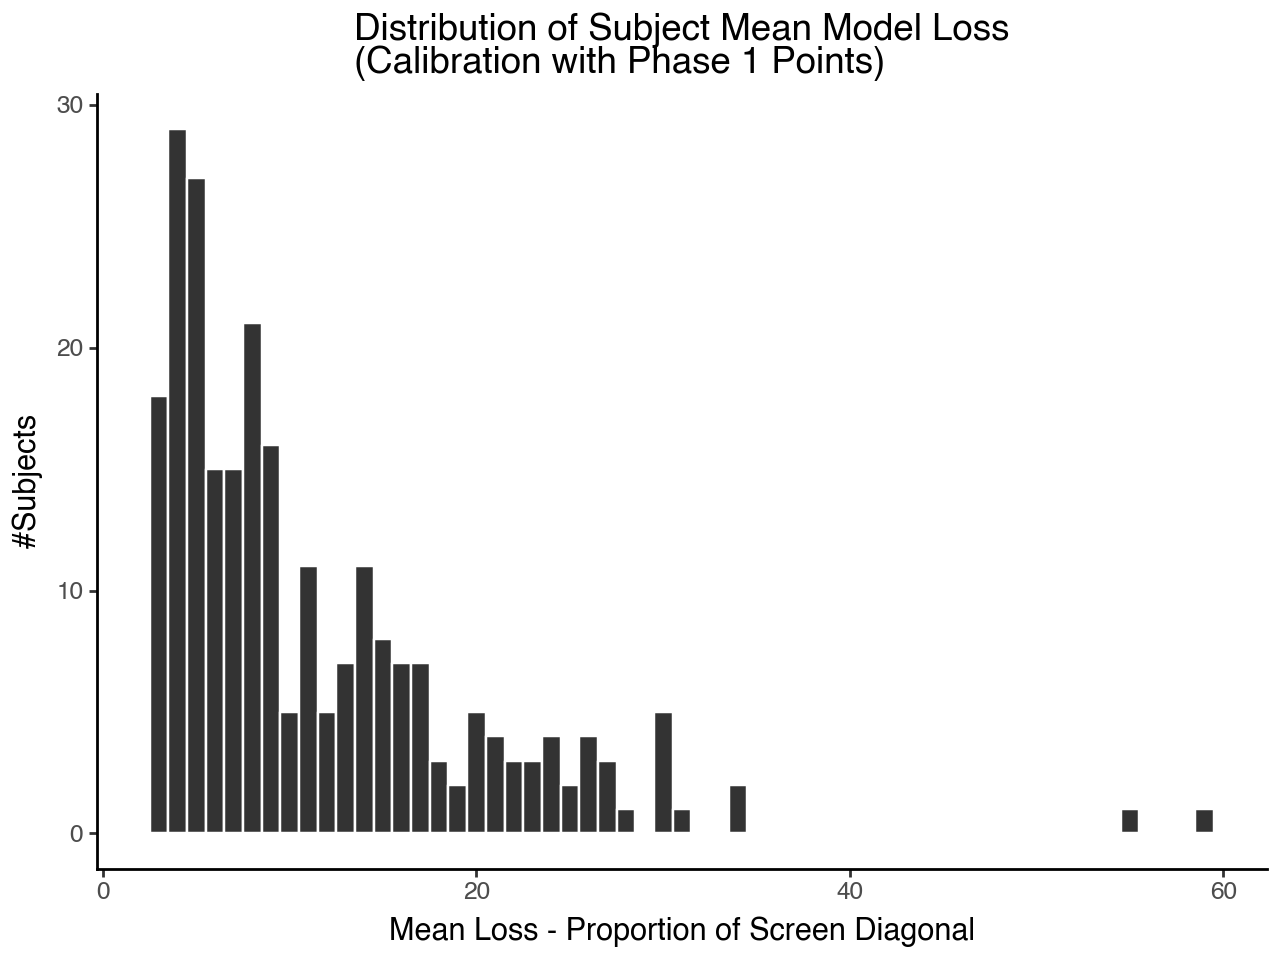

In [53]:
subj_mean_losses_df_p1 = pd.DataFrame({'mean_loss': subj_mean_losses_p1})

subj_mean_losses_plot_p1 = (ggplot(subj_mean_losses_df_p1, aes(x='mean_loss'))
 + geom_histogram(binwidth=1, color='white', fill='#333')
 + labs(title='Distribution of Subject Mean Model Loss\n(Calibration with Phase 1 Points)',
       x='Mean Loss - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_plot_p1

## Phase 2 calibration loss distribution across subjects

In [54]:
pred_p2 = full_model.predict(test_ds_p2.batch(5))

50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [55]:
batch_losses_p2 = []
subject_ids_p2 = []

for pred_batch, ds_batch in zip(pred_p2, test_ds_p2.batch(1).as_numpy_iterator()):
    y_true = ds_batch[1]
    subject_id = ds_batch[2][0]
    mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

    batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
    batch_point_losses = batch_point_losses[mask == 1]

    batch_losses_p2.append(batch_point_losses)
    subject_ids_p2.append(subject_id)

In [56]:
subj_mean_losses_p2 = [np.mean(losses) for losses in batch_losses_p2]

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


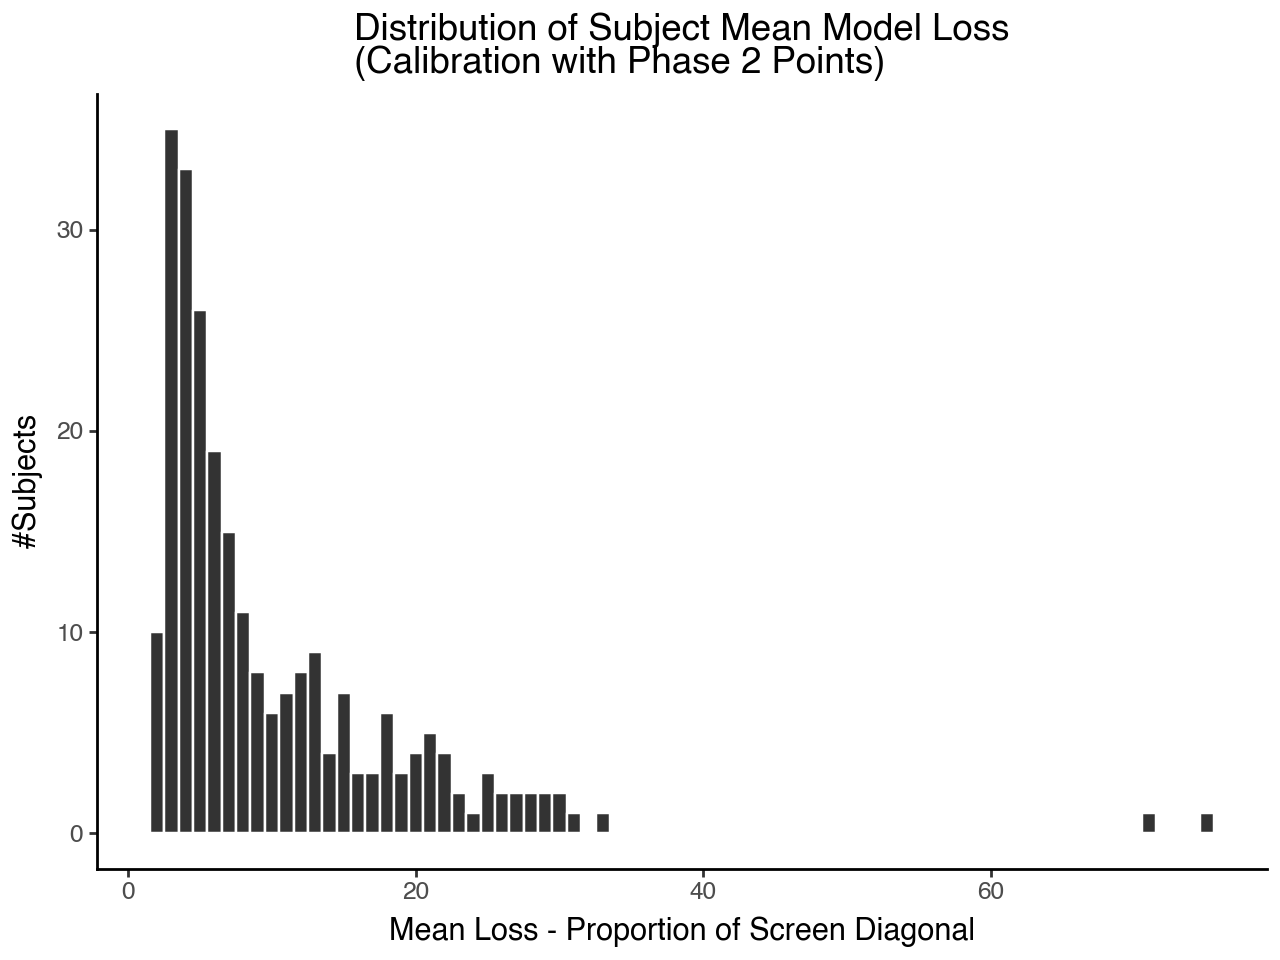

In [57]:
subj_mean_losses_df_p2 = pd.DataFrame({'mean_loss': subj_mean_losses_p2})

subj_mean_losses_plot_p2 = (ggplot(subj_mean_losses_df_p2, aes(x='mean_loss'))
 + geom_histogram(binwidth=1, color='white', fill='#333')
 + labs(title='Distribution of Subject Mean Model Loss\n(Calibration with Phase 2 Points)',
       x='Mean Loss - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_plot_p2

## Create composite histogram

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


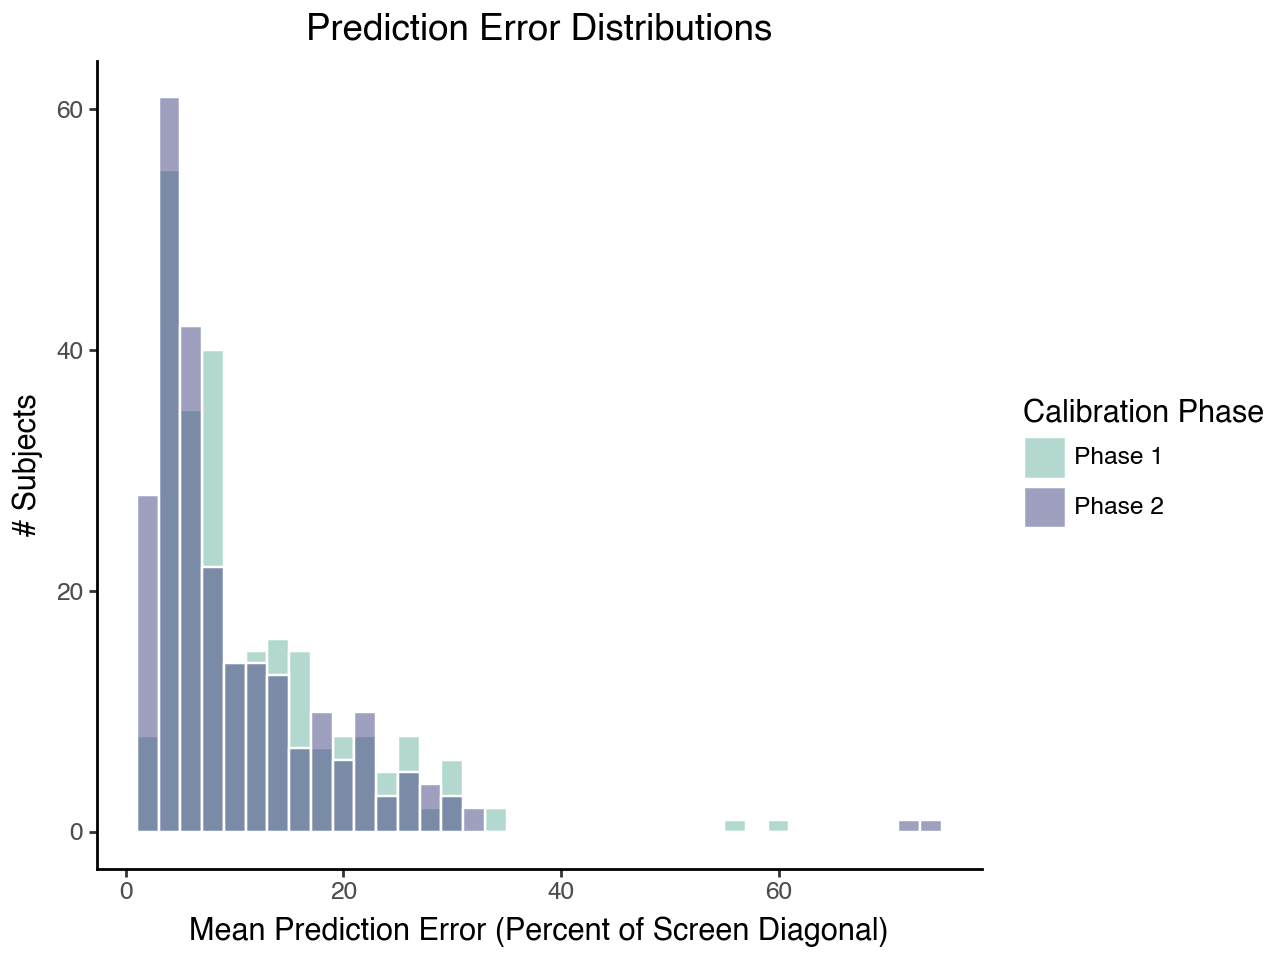

In [58]:
composite_table = pd.DataFrame({'subject_id': subject_ids, 'mean_loss_p1': subj_mean_losses_p1, 'mean_loss_p2': subj_mean_losses_p2})
composite_table_pivot_long = composite_table.melt(id_vars=['subject_id'], var_name='phase', value_name='mean_loss')

composite_plot = (ggplot(composite_table_pivot_long, aes(x='mean_loss', fill='phase'))
 + geom_histogram(binwidth=2, alpha=0.5, color='white', position="identity")
 + labs(title='Prediction Error Distributions',
       x='Mean Prediction Error (Percent of Screen Diagonal)',
       y='# Subjects')
 + scale_fill_manual(values=["#69b3a2", "#404080"], labels=["Phase 1", "Phase 2"], name="Calibration Phase")
 + theme_classic()
)

composite_plot

## Upload Analysis \#1 data to W&B

In [59]:
# Create table with subject, phase 1 loss, and phase 2 loss
analysis_1_table = wandb.Table(columns=["subject_id", "phase_1_loss", "phase_2_loss"], data=list(zip(subject_ids, subj_mean_losses_p1, subj_mean_losses_p2)))

In [60]:
analysis_1_table.data

[[np.int64(2544019960324), np.float32(3.1231868), np.float32(2.2471707)],
 [np.int64(1545426725871), np.float32(5.452763), np.float32(3.9688663)],
 [np.int64(2389290464191), np.float32(6.61674), np.float32(5.8437643)],
 [np.int64(13389585215), np.float32(4.910132), np.float32(5.887848)],
 [np.int64(190860173358), np.float32(8.621619), np.float32(9.565804)],
 [np.int64(2768461212563), np.float32(12.733161), np.float32(8.212025)],
 [np.int64(556052438853), np.float32(3.0019193), np.float32(2.1746721)],
 [np.int64(505133040007), np.float32(3.7193668), np.float32(3.3557956)],
 [np.int64(1545299779492), np.float32(25.928652), np.float32(19.418442)],
 [np.int64(2422749446868), np.float32(7.7521143), np.float32(7.1460204)],
 [np.int64(82968733662), np.float32(3.8625848), np.float32(2.87431)],
 [np.int64(1307111734285), np.float32(23.989492), np.float32(21.146006)],
 [np.int64(2265027059643), np.float32(15.0206), np.float32(10.514291)],
 [np.int64(1751047273907), np.float32(7.9510374), np.floa

In [61]:
wandb.log({"analysis_1_table": analysis_1_table})

In [62]:
# convert plotnine to image and save as image
composite_plot.save('analysis_1_composite_plot.png', width=10, height=5)
wandb.log({"analysis_1_histogram": wandb.Image('analysis_1_composite_plot.png')})


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_1_composite_plot.png
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


# Analysis #2: Image Quality metrics vs. accuracy

## Download the image quality metrics from OSF

In [50]:
!osf -p uf2sh fetch image-quality-metrics-subject-level.csv

100% 70.0k/70.0k [00:00<00:00, 246kbytes/s]


In [51]:
df_image_quality = pd.read_csv('image-quality-metrics-subject-level.csv')

In [52]:
df_image_quality.head()

,subject_id,brightness_mean,brightness_std,contrast_mean,contrast_std,entropy_mean,entropy_std,laplacian_variance_mean,laplacian_variance_std,gradient_magnitude_mean,gradient_magnitude_std,blur_detection_mean,blur_detection_std,noise_estimation_mean,noise_estimation_std,phase_1_count,phase_2_count
0,13389585215,122.516162,2.213714,44.386757,1.586937,7.461434,0.048479,336.010478,94.648889,91.465367,7.855967,336.010478,94.648889,63.312245,1.916063,144,144
1,43470693621,117.663361,3.725072,44.106767,1.005724,7.356355,0.046730,269.278325,67.770894,85.634827,5.669005,269.278325,67.770894,63.504523,1.972885,144,144
2,45129608316,113.356417,3.033780,31.176296,2.203237,6.879860,0.089051,218.671992,63.118183,63.769301,4.658143,218.671992,63.118183,62.644547,1.635375,6,0
3,60722210910,30.975851,7.232565,18.977919,6.102619,5.785024,0.454449,99.295062,59.772809,26.010741,8.647762,99.295062,59.772809,52.333712,8.977695,138,63
4,62495457199,160.693465,12.969692,44.145459,4.755742,7.411326,0.153534,567.670864,199.714824,95.028211,10.688830,567.670864,199.714824,71.682176,3.135231,139,138


In [53]:
df_analysis_1 = pd.DataFrame({'subject_id': subject_ids, 'mean_loss_p1': subj_mean_losses_p1, 'mean_loss_p2': subj_mean_losses_p2})

In [54]:
# merge image quality data
df_analysis_1 = df_analysis_1.merge(df_image_quality, on='subject_id')

## Compute correlation between image quality metrics and accuracy at subject level

In [55]:
# run correlations for mean_loss against each quality measure
df_analysis_1.corr()

,subject_id,mean_loss_p1,mean_loss_p2,brightness_mean,brightness_std,contrast_mean,contrast_std,entropy_mean,entropy_std,laplacian_variance_mean,laplacian_variance_std,gradient_magnitude_mean,gradient_magnitude_std,blur_detection_mean,blur_detection_std,noise_estimation_mean,noise_estimation_std,phase_1_count,phase_2_count
subject_id,1.000000,0.032842,0.066170,0.052455,-0.002001,0.069444,-0.041526,0.116181,-0.056232,0.100558,0.090257,0.112833,0.040147,0.100558,0.090257,0.121501,-0.029306,0.111178,0.048362
mean_loss_p1,0.032842,1.000000,0.769780,-0.336618,0.351371,-0.272707,0.350374,-0.426858,0.466070,-0.097075,0.009648,-0.319139,0.281510,-0.097075,0.009648,-0.343556,0.406446,-0.490333,-0.540040
mean_loss_p2,0.066170,0.769780,1.000000,-0.302726,0.233415,-0.256545,0.277390,-0.347613,0.357150,-0.136989,-0.059639,-0.295115,0.155878,-0.136989,-0.059639,-0.250925,0.331272,-0.342642,-0.635753
brightness_mean,0.052455,-0.336618,-0.302726,1.000000,-0.043951,0.623027,-0.227036,0.702871,-0.503731,0.301895,0.229303,0.640956,0.019693,0.301895,0.229303,0.485018,-0.453939,0.319948,0.276228
brightness_std,-0.002001,0.351371,0.233415,-0.043951,1.000000,0.118260,0.584492,0.064992,0.444218,-0.010637,0.148315,0.012238,0.606817,-0.010637,0.148315,0.030183,0.475543,-0.088561,-0.169700
contrast_mean,0.069444,-0.272707,-0.256545,0.623027,0.118260,1.000000,-0.008885,0.857295,-0.384722,0.486135,0.470246,0.824446,0.266313,0.486135,0.470246,0.469938,-0.264018,0.291720,0.298541
contrast_std,-0.041526,0.350374,0.277390,-0.227036,0.584492,-0.008885,1.000000,-0.098139,0.561127,-0.090350,0.056889,-0.153782,0.502113,-0.090350,0.056889,-0.127370,0.530190,-0.070256,-0.104386
entropy_mean,0.116181,-0.426858,-0.347613,0.702871,0.064992,0.857295,-0.098139,1.000000,-0.604575,0.417537,0.395090,0.801521,0.210951,0.417537,0.395090,0.748813,-0.464304,0.494936,0.432550
entropy_std,-0.056232,0.466070,0.357150,-0.503731,0.444218,-0.384722,0.561127,-0.604575,1.000000,-0.222281,-0.102972,-0.443232,0.403998,-0.222281,-0.102972,-0.530470,0.875541,-0.328731,-0.300874
laplacian_variance_mean,0.100558,-0.097075,-0.136989,0.301895,-0.010637,0.486135,-0.090350,0.417537,-0.222281,1.000000,0.903746,0.703050,0.331450,1.000000,0.903746,0.561286,-0.169337,0.124478,0.148894


# Analysis #3: Accuracy plots for individual subjects

# Analysis #3: Build Comprehensive Predictions DataFrame

Create a comprehensive DataFrame containing all predictions and actual coordinates for easier analysis.

In [95]:
def build_predictions_dataframe():
    """
    Build a comprehensive DataFrame with subject_id, predicted coordinates, 
    and actual coordinates for both phases. Generates predictions internally.
    """
    all_data = []
    
    print("Generating Phase 1 predictions...")
    pred_p1_internal = full_model.predict(test_ds_p1.batch(5))
    
    print("Generating Phase 2 predictions...")
    pred_p2_internal = full_model.predict(test_ds_p2.batch(5))
    
    print("Processing Phase 1 data...")
    for subject_idx, (pred_batch, ds_batch) in enumerate(zip(pred_p1_internal, test_ds_p1.batch(1).as_numpy_iterator())):
        subject_id = subject_ids[subject_idx]
        actual_coords = ds_batch[1].squeeze()  # Remove batch dimension
        mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)
        
        # Filter by mask to get only target points
        pred_coords = pred_batch[mask == 1]
        actual_coords_filtered = actual_coords[mask == 1]
        
        # Store data for this subject and phase
        for point_idx, (pred_coord, actual_coord) in enumerate(zip(pred_coords, actual_coords_filtered)):
            error = normalized_weighted_euc_dist(
                np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
            )
            error_float = float(error.numpy()[0])  # Convert tensor to float
            
            all_data.append({
                'subject_id': subject_id,
                'point_id': point_idx,
                'x_actual': actual_coord[0],
                'y_actual': actual_coord[1],
                'x_predicted': pred_coord[0],
                'y_predicted': pred_coord[1],
                'calibration_phase': 1,
                'error': error_float
            })
    
    print("Processing Phase 2 data...")
    for subject_idx, (pred_batch, ds_batch) in enumerate(zip(pred_p2_internal, test_ds_p2.batch(1).as_numpy_iterator())):
        subject_id = subject_ids[subject_idx]
        actual_coords = ds_batch[1].squeeze()  # Remove batch dimension
        mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)
        
        # Filter by mask to get only target points
        pred_coords = pred_batch[mask == 1]
        actual_coords_filtered = actual_coords[mask == 1]
        
        # Store data for this subject and phase
        for point_idx, (pred_coord, actual_coord) in enumerate(zip(pred_coords, actual_coords_filtered)):
            error = normalized_weighted_euc_dist(
                np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
            )
            error_float = float(error.numpy()[0])  # Convert tensor to float
            
            all_data.append({
                'subject_id': subject_id,
                'point_id': point_idx,
                'x_actual': actual_coord[0],
                'y_actual': actual_coord[1],
                'x_predicted': pred_coord[0],
                'y_predicted': pred_coord[1],
                'calibration_phase': 2,
                'error': error_float
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    print(f"DataFrame created with {len(df)} rows, {len(df['subject_id'].unique())} unique subjects, and phases {df['calibration_phase'].unique()}")
    return df

# Build the comprehensive predictions DataFrame
predictions_df = build_predictions_dataframe()
predictions_df.head()

Generating Phase 1 predictions...
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
Generating Phase 2 predictions...
Generating Phase 2 predictions...


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
2025-05-26 14:54:14.410718: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
Processing Phase 1 data...
Processing Phase 1 data...
Processing Phase 2 data...
Processing Phase 2 data...
DataFrame created with 57322 rows, 246 unique subjects, and phases [1 2]
DataFrame created with 57322 rows, 246 unique subjects, and phases [1 2]


,subject_id,point_id,x_actual,y_actual,x_predicted,y_predicted,calibration_phase,error
0,2544019960324,0,0.05,0.8375,0.077640,0.822448,1,2.519608
1,2544019960324,1,0.17,0.1625,0.162676,0.165391,1,0.653873
2,2544019960324,2,0.41,0.3875,0.419430,0.383719,1,0.842546
3,2544019960324,3,0.17,0.8375,0.174654,0.753373,1,4.143915
4,2544019960324,4,0.29,0.2750,0.338516,0.269611,1,4.236955


## Create Plotting Function Using DataFrame

In [102]:
def plot_predictions_vs_actual_from_df(df, subject_id, title_suffix=""):
    """
    Plot predicted vs actual coordinates with connecting lines using DataFrame.
    Produces two plots/facets: one for phase 1 predictions, one for phase 2 predictions.
    """
    # Filter data for this subject
    subject_data = df[df['subject_id'] == subject_id].copy()
    if len(subject_data) == 0:
        print(f"No data found for subject {subject_id}")
        return None

    # Prepare data for plotting
    plot_data = []
    line_data = []
    
    for _, row in subject_data.iterrows():
        phase = f"Phase {row['calibration_phase']}"
        point_id = row['point_id']
        
        # Add actual point
        plot_data.append({
            'x': row['x_actual'],
            'y': row['y_actual'],
            'point_type': 'Actual',
            'phase': phase,
            'point_id': point_id
        })
        
        # Add predicted point
        plot_data.append({
            'x': row['x_predicted'],
            'y': row['y_predicted'],
            'point_type': 'Predicted',
            'phase': phase,
            'point_id': point_id
        })
        
        # Add line data (two points per line: actual and predicted)
        line_data.extend([
            {
                'x': row['x_actual'],
                'y': row['y_actual'],
                'phase': phase,
                'group': f"{phase}_{point_id}"
            },
            {
                'x': row['x_predicted'],
                'y': row['y_predicted'],
                'phase': phase,
                'group': f"{phase}_{point_id}"
            }
        ])
    
    plot_df = pd.DataFrame(plot_data)
    lines_df = pd.DataFrame(line_data)
    
    # Create the plot
    plot = (
        ggplot()
        + geom_line(lines_df, aes(x="x", y="y", group="group"), color="darkred", alpha=0.6)
        + geom_point(plot_df[plot_df['point_type'] == 'Actual'], 
                    aes(x="x", y="y"), color="gray", size=3, alpha=0.8)
        + geom_point(plot_df[plot_df['point_type'] == 'Predicted'], 
                    aes(x="x", y="y"), color="darkred", size=3, alpha=0.8)
        + scale_y_reverse()
        + scale_x_continuous(limits=(0, 1))
        + scale_y_continuous(limits=(0, 1))
        + facet_wrap("~phase", ncol=1)
        + labs(
            title=f"Subject {subject_id} - Actual vs Predicted Coordinates{title_suffix}",
            x="",
            y=""
        )
        + theme_classic()
        + theme(
            plot_title=element_text(hjust=0.5),
            aspect_ratio=9/16,  # 16:9 aspect ratio (inverted since y is height)
            axis_text=element_blank(),
            axis_ticks=element_blank(),
            axis_line=element_blank()
        )
    )
    return plot

## Identify Representative Subjects

In [97]:
# Calculate subject-level statistics from predictions_df
subject_stats = (
    predictions_df
    .groupby(['subject_id', 'calibration_phase'])['error']
    .mean()
    .reset_index()
    .pivot(index='subject_id', columns='calibration_phase', values='error')
    .reset_index()
    .rename(columns={1: 'mean_error_p1', 2: 'mean_error_p2'})
)

# Sort by Phase 1 performance
subject_stats_sorted = subject_stats.sort_values('mean_error_p1')

# Get representative subjects
best_subject = subject_stats_sorted.iloc[0]
median_subject = subject_stats_sorted.iloc[len(subject_stats_sorted) // 2]
worst_subject = subject_stats_sorted.iloc[-1]

print("Representative Subjects:")
print(f"Best: Subject {best_subject['subject_id']} (P1 Error: {best_subject['mean_error_p1']:.4f}, P2 Error: {best_subject['mean_error_p2']:.4f})")
print(f"Median: Subject {median_subject['subject_id']} (P1 Error: {median_subject['mean_error_p1']:.4f}, P2 Error: {median_subject['mean_error_p2']:.4f})")
print(f"Worst: Subject {worst_subject['subject_id']} (P1 Error: {worst_subject['mean_error_p1']:.4f}, P2 Error: {worst_subject['mean_error_p2']:.4f})")

Representative Subjects:
Best: Subject 2228672337078.0 (P1 Error: 2.5576, P2 Error: 2.1840)
Median: Subject 2803905540190.0 (P1 Error: 8.4146, P2 Error: 6.2809)
Worst: Subject 2725071097112.0 (P1 Error: 59.3206, P2 Error: 28.8292)


## Generate Prediction Plots for Representative Subjects

In [103]:
# Create visualization directory
os.makedirs("analysis_3_predictions", exist_ok=True)

# Generate plots for representative subjects
representative_subjects = [
    (best_subject['subject_id'], "best"),
    (median_subject['subject_id'], "median"), 
    (worst_subject['subject_id'], "worst")
]

for subject_id, performance_level in representative_subjects:
    plot = plot_predictions_vs_actual_from_df(predictions_df, subject_id)
    if plot is not None:
        filename = f"analysis_3_predictions/{performance_level}_subject.png"
        plot.save(filename, width=10, height=8)
        print(f"Saved plot: {filename}")

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 8 in image.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_3_predictions/best_subject.png


Saved plot: analysis_3_predictions/best_subject.png


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 8 in image.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_3_predictions/median_subject.png
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 14 rows containing missing values.


Saved plot: analysis_3_predictions/median_subject.png
Saved plot: analysis_3_predictions/worst_subject.png


/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 8 in image.
/Users/jdeleeuw/Documents/GitHub/eye-tracking-training/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_3_predictions/worst_subject.png


## Upload Analysis #3 Files to OSF and W&B

In [ ]:
# Upload files to OSF
upload_to_analysis_osf("analysis_3_predictions", [
    "predictions_dataframe.csv",
    "best_subject_phase1.png",
    "best_subject_phase2.png", 
    "median_subject_phase1.png",
    "median_subject_phase2.png",
    "worst_subject_phase1.png",
    "worst_subject_phase2.png"
])

In [ ]:
# Log prediction plots and data to W&B
wandb.log({
    "prediction_plots/best_subject_phase1": wandb.Image('analysis_3_predictions/best_subject_phase1.png'),
    "prediction_plots/best_subject_phase2": wandb.Image('analysis_3_predictions/best_subject_phase2.png'),
    "prediction_plots/median_subject_phase1": wandb.Image('analysis_3_predictions/median_subject_phase1.png'),
    "prediction_plots/median_subject_phase2": wandb.Image('analysis_3_predictions/median_subject_phase2.png'),
    "prediction_plots/worst_subject_phase1": wandb.Image('analysis_3_predictions/worst_subject_phase1.png'),
    "prediction_plots/worst_subject_phase2": wandb.Image('analysis_3_predictions/worst_subject_phase2.png')
})

# Create and log subject statistics table
subject_stats_table = wandb.Table(
    columns=["subject_id", "mean_error_p1", "mean_error_p2"], 
    data=subject_stats.values.tolist()
)
wandb.log({"subject_error_statistics": subject_stats_table})

## Example: Additional Analysis Using DataFrame

Now that we have the comprehensive DataFrame, we can easily perform additional analyses.

In [ ]:
# Example: Compare error distributions between phases
error_comparison_df = predictions_df.copy()
error_comparison_df['phase'] = error_comparison_df['calibration_phase'].map({1: 'Phase 1', 2: 'Phase 2'})

error_comparison_plot = (
    ggplot(error_comparison_df, aes(x='error', fill='phase'))
    + geom_histogram(alpha=0.7, position='identity', bins=50)
    + scale_fill_manual(values=['#69b3a2', '#404080'])
    + labs(
        title='Prediction Error Distribution by Calibration Phase',
        x='Prediction Error',
        y='Count',
        fill='Calibration Phase'
    )
    + theme_classic()
)

error_comparison_plot.save('analysis_3_predictions/error_comparison_by_phase.png', width=10, height=6)
error_comparison_plot

In [ ]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_line, scale_y_reverse, scale_color_manual, labs, theme_classic

def plot_pred_vs_target_grid(target_coords, pred_coords, title="Predicted vs Target Grid"):
  """
  Plots the target coordinate grid and the predicted locations, connecting each prediction to its target.
  Args:
    target_coords (np.ndarray): Array of shape (N, 2) with target (x, y) coordinates.
    pred_coords (np.ndarray): Array of shape (N, 2) with predicted (x, y) coordinates.
    title (str): Plot title.
  Returns:
    plotnine.ggplot: The plot object.
  """

  # Prepare dataframes
  df_targets = pd.DataFrame(target_coords, columns=["x", "y"])
  df_targets["type"] = "target"
  df_targets["idx"] = range(len(df_targets))

  df_preds = pd.DataFrame(pred_coords, columns=["x", "y"])
  df_preds["type"] = "prediction"
  df_preds["idx"] = range(len(df_preds))

  # For connecting lines
  df_lines = pd.DataFrame({
    "x": np.concatenate([df_targets["x"], df_preds["x"]]),
    "y": np.concatenate([df_targets["y"], df_preds["y"]]),
    "idx": np.concatenate([df_targets["idx"], df_preds["idx"]]),
    "group": np.repeat(range(len(df_targets)), 2)
  })


  p = (
    ggplot()
    + geom_point(df_targets, aes(x="x", y="y", color='"Target"'), size=3)
    + geom_point(df_preds, aes(x="x", y="y", color='"Prediction"'), size=3, alpha=0.7)
    + geom_line(df_lines, aes(x="x", y="y", group="group"), color="gray", alpha=0.5)
    + scale_color_manual(values={"Target": "red", "Prediction": "blue"})
    + scale_y_reverse()
    + labs(title=title, x="X", y="Y", color="Point Type")
    + theme_classic()
  )
  return p